In [1]:
!pip install idx2numpy
!pip install sklearn
!pip install pandas_ml
!pip install opencv-python


import time
import idx2numpy
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score,precision_recall_fscore_support,accuracy_score
from pandas_ml import ConfusionMatrix
from sklearn.preprocessing import StandardScaler

import cv2
from sklearn import svm

# Importing Dataset

In [2]:
train_images_path = r'E:\EP2016\7th sem\EE6132 DL\Ass1\Dataset\train-images.idx3-ubyte'
test_images_path = r'E:\EP2016\7th sem\EE6132 DL\Ass1\Dataset\t10k-images.idx3-ubyte'
train_labels_path = r'E:\EP2016\7th sem\EE6132 DL\Ass1\Dataset\train-labels.idx1-ubyte'
test_labels_path = r'E:\EP2016\7th sem\EE6132 DL\Ass1\Dataset\t10k-labels.idx1-ubyte'
train_images = idx2numpy.convert_from_file(train_images_path)
test_images = idx2numpy.convert_from_file(test_images_path)
train_labels = idx2numpy.convert_from_file(train_labels_path)
test_labels = idx2numpy.convert_from_file(test_labels_path)

In [3]:
train_X = np.transpose(train_images.reshape([60000,784]))                    # train_X  (784,60000)
train_X = train_X/255.
test_X = np.transpose(test_images.reshape([10000,784]))                       # test_X   (784,10000)
test_X = test_X/255.
train_Y = train_labels
test_Y = test_labels

# One hot encoding of labels 

In [4]:
train_Y = np.zeros((10,60000))
for i in range(60000):
    train_Y[train_labels[i],i] = 1                                            #train_Y   (10,60000)
    
test_Y = np.zeros((10,10000))
for i in range(10000):
    test_Y[test_labels[i],i] = 1

# Activation Functions

In [14]:
def activation_function(string,Z):
    if string == 'sigmoid':
        A = 1/(1+np.exp(-1*Z))
    if string == 'tanh':
        A = (np.exp(Z)-np.exp(-1*Z))/(np.exp(Z)+np.exp(-1*Z))
    if string == 'relu':
        A = (Z + abs(Z))/2
    if string == 'softmax':
        A = np.exp(Z)/np.sum(np.exp(Z),axis = 0)
    return A

# Initialize Parameters

In [15]:
def initialize_parameters(layer_dims):
    parameters = {}
    for i in range(1,len(layer_dims)):
        d = np.sqrt(6/(layer_dims[i-1]+layer_dims[i]))
        parameters['W'+str(i)] = np.random.uniform(-1*d,d,(layer_dims[i],layer_dims[i-1]))
        parameters['b'+str(i)] = np.zeros((layer_dims[i],1))

    return parameters

# Forward Propagation

In [16]:
def forward_propagation(X,parameters,activation):
    A = {}
    Z = {}
    for i in range(1,len(parameters)//2+1):
        if (i == 1):
            Z['Z'+str(i)] = np.matmul(parameters['W'+str(i)],X) + parameters['b'+str(i)]
            A['A'+str(i)] = activation_function(activation[i-1],Z['Z'+str(i)])
        else:
            Z['Z'+str(i)] = np.matmul(parameters['W'+str(i)],A['A'+str(i-1)]) + parameters['b'+str(i)]
            A['A'+str(i)] = activation_function(activation[i-1],Z['Z'+str(i)])
   
    return A,Z
    

# Computing Cost 

In [17]:
def compute_cost(A_L,Y):
    m =Y.shape[1]
    cost = -(1/m)*sum(sum(Y*np.log(A_L)))
    return cost

# Backward Propagation

In [18]:

def backward_propagation(parameters,A,Z,X,Y,activation):
    A['A0'] = X
    del_L = A['A' + str(len(Z))] - Y
    delta = [del_L]
    dW = {}
    db = {}
    L = len(Z)
    m = X.shape[1]
    for i in range(1,L+1):
        dW['dW'+str(L-i+1)] = (1/m)*np.matmul(delta[-1],np.transpose(A['A'+str(L-i)]))
        db['db'+str(L-i+1)] = (1/m)*np.sum(delta[-1],axis = 1,keepdims = True)
        if (i == L):
            delta.append(np.matmul(np.transpose(parameters['W'+str(L-i+1)]),delta[-1]))
        else:
            delta.append(np.matmul(np.transpose(parameters['W'+str(L-i+1)]),delta[-1])*(activation_derivatives(activation[i],Z['Z'+str(L-i)])))

        
   
            
    return dW,db   
    
    

In [19]:
def update_parameters(dW,db,lr,parameters):
    for i in range(1,len(parameters)//2+1):
        parameters['W'+str(i)] = parameters['W'+str(i)] - lr*dW['dW'+str(i)]
        parameters['b'+str(i)] = parameters['b'+str(i)] - lr*db['db'+str(i)]
    
    return parameters

# Activation Derivatives

In [20]:
def activation_derivatives(string,Z):
    if string == 'sigmoid':
        A_der = activation_function('sigmoid',Z)*(1-activation_function('sigmoid',Z))
    if string == 'relu':
        A_der = np.where(Z>0,1,0)
    if string == 'tanh':
        A_der = 1-(activation_function('tanh',Z))**2   
    return A_der

In [21]:
def train_model(train_X,test_X, test_Y,train_Y, activation ,batch_size, epochs,lr):
    data = np.concatenate((train_X.T,train_Y.T),axis = 1)
    np.random.shuffle(data)
    X_train = data[:,:784]
    Y_train = data[:,784:]
    cost_train = []
    cost_test = []
    parameters = initialize_parameters([784,500,250,100,10])
    activation_rev = activation[::-1]
    x = 1
    for i in range(epochs):
        train_cost = 0
        test_cost = 0
        print('Epoch '+str(i)+' [' ,end='')
        for j in range(0, X_train.shape[0], batch_size):
                print('=',end ='')
                X_train_mini = X_train[j:j + batch_size,:]
                Y_train_mini = Y_train[j:j + batch_size,:]
                A,Z= forward_propagation(X_train_mini.T, parameters, activation)
                
                
                dW,db = backward_propagation(parameters,A,Z,X_train_mini.T,Y_train_mini.T,activation_rev)

                parameters = update_parameters(dW,db,lr,parameters)
                if (x%200==0):
                    A1,_= forward_propagation(train_X, parameters, activation)
                    train_pred = A1['A'+str(len(A1))]
                    A2,_= forward_propagation(test_X, parameters, activation)
                    test_pred = A2['A'+str(len(A2))]


                    train_cost = round(compute_cost(train_pred,train_Y),4)
                    test_cost = round(compute_cost(test_pred,test_Y),4)
                    cost_train.append(train_cost)
                    cost_test.append(test_cost)

                x = x+1
        print(train_cost,test_cost)
             
    return cost_train,cost_test,parameters

In [13]:
cost_train,cost_test,parameters = train_model(train_X,test_X,test_Y,train_Y,['tanh','tanh','tanh','softmax'],batch_size = 64,epochs = 15,lr = 0.02)

Epoch 0 [============================================================================================================================

KeyboardInterrupt: 

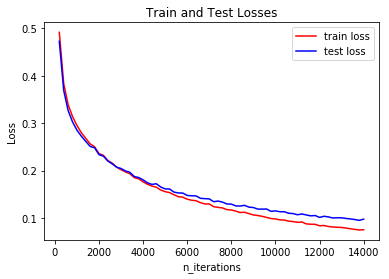

In [340]:

epoch = [200*i for i in range(1,71)]
plt.plot(epoch,cost_train,'-r')
plt.plot(epoch,cost_test,'-b', label= 'test loss')
plt.title('Train and Test Losses')
plt.xlabel('n_iterations')
plt.ylabel('Loss')
plt.gca().legend(('train loss','test loss'))#,'test loss'))
plt.savefig('relu_0.02traintest_loss.png')
plt.show()


In [22]:
def predict(X,parameters,activation):
    A,_= forward_propagation(X, parameters, activation)
   # print(compute_cost(Y_pred_proba,train_Y))
    Y_pred_proba = A['A'+str(len(A))]
    Y_pred  = np.zeros(X.shape[1],dtype = int)
    for i in range(X.shape[1]):
        Y_pred[i] = np.argmax(Y_pred_proba[:,i])
    return Y_pred
        
    
    

In [23]:
def metrics(train_X,test_X,parameters,activation,train_labels,test_labels):
    train_y_pred = predict(train_X,parameters,activation)
    train_accuracy = sum(train_labels==train_y_pred)/60000
    print('Training Accuracy = ',train_accuracy)
    test_y_pred = predict(test_X,parameters,activation)
    test_accuracy = sum(test_labels==test_y_pred)/10000
    print('Test Accuracy = ',test_accuracy)
    cfm = ConfusionMatrix(test_labels,test_y_pred)
    precision,recall,f1_score,_=precision_recall_fscore_support(test_labels,test_y_pred,average = 'weighted')
    print('precision = ',precision, 'and '+ 'recall = ', recall, 'and f1_score =' ,f1_score)
    
    return cfm


In [350]:
cfm = metrics(train_X,test_X,parameters,['tanh','tanh','tanh','softmax'],train_labels,test_labels)
cfm

Training Accuracy =  0.9795833333333334


In [24]:
def bck_prop_return_delta(parameters,A,Z,X,Y,activation):
    A['A0'] = X 
    del_L = A['A' + str(len(Z))] - Y
    delta = [del_L]
    dW = {}
    db = {}
    L = len(Z)
    m = X.shape[1]
    for i in range(1,L+1):
        dW['dW'+str(L-i+1)] = (1/m)*np.matmul(delta[-1],np.transpose(A['A'+str(L-i)]))
        db['db'+str(L-i+1)] = (1/m)*np.sum(delta[-1],axis = 1,keepdims = True)
        #if (i == L):
        #    delta.append(np.matmul(np.transpose(parameters['W'+str(L-i+1)]),delta[-1]))
        if(i != L):
            delta.append(np.matmul(np.transpose(parameters['W'+str(L-i+1)]),delta[-1])*(activation_derivatives(activation[i],Z['Z'+str(L-i)])))

        
   
            
    return dW,db,delta

In [25]:
def inactive_neurons(train_X,train_Y, activation ,batch_size, epochs,lr):
    
    data = np.concatenate((train_X.T,train_Y.T),axis = 1)
    np.random.shuffle(data)
    X_train = data[:,:784]
    Y_train = data[:,784:]
    parameters = initialize_parameters([784,500,250,100,10])
    activation_rev = activation[::-1]
    inactive_3 = []
    inactive_2 = []
    inactive_1 = []
    inactive_tot = []
    for i in range(epochs):
        
        
       # print('Epoch '+str(i)+' [' ,end='')
        for j in range(0, X_train.shape[0], batch_size):
                print(i,j)
                #print('=',end ='')
                X_train_mini = X_train[j:j + batch_size,:]
                Y_train_mini = Y_train[j:j + batch_size,:]
                A,Z= forward_propagation(X_train_mini.T, parameters, activation)
                
                dW,db,delta =bck_prop_return_delta(parameters,A,Z,X_train_mini.T,Y_train_mini.T,activation_rev)
                #print(np.mean(delta[-3],axis = 1).shape)
                #print(np.mean(delta[-3],axis = 1).shape[0])
                inactive_neurons_3 = sum(sum(np.where(abs(delta[-3])<1e-5,1,0)))/(delta[-3].shape[0]*delta[-3].shape[1])
                inactive_neurons_2 = sum(sum(np.where(abs(delta[-2])<1e-5,1,0)))/(delta[-2].shape[0]*delta[-2].shape[1])
                inactive_neurons_1 = sum(sum(np.where(abs(delta[-1])<1e-5,1,0)))/(delta[-1].shape[0]*delta[-1].shape[1])
                inactive_neurons_tot = inactive_neurons_1+inactive_neurons_2+inactive_neurons_3
                inactive_3.append(inactive_neurons_3)
                inactive_2.append(inactive_neurons_2)
                inactive_1.append(inactive_neurons_1)
                inactive_tot.append(inactive_neurons_tot)
                parameters = update_parameters(dW,db,lr,parameters)
              

       
             
    return inactive_1, inactive_2, inactive_3,inactive_tot

In [470]:
inactive_1, inactive_2, inactive_3,inactive_tot= inactive_neurons(train_X,train_Y, activation ,batch_size, epochs,lr = 0.2)

0 0
0 64
0 128
0 192
0 256
0 320
0 384
0 448
0 512
0 576
0 640
0 704
0 768
0 832
0 896
0 960
0 1024
0 1088
0 1152
0 1216
0 1280
0 1344
0 1408
0 1472
0 1536
0 1600
0 1664
0 1728
0 1792
0 1856
0 1920
0 1984
0 2048
0 2112
0 2176
0 2240
0 2304
0 2368
0 2432
0 2496
0 2560
0 2624
0 2688
0 2752
0 2816
0 2880
0 2944
0 3008
0 3072
0 3136
0 3200
0 3264
0 3328
0 3392
0 3456
0 3520
0 3584
0 3648
0 3712
0 3776
0 3840
0 3904
0 3968
0 4032
0 4096
0 4160
0 4224
0 4288
0 4352
0 4416
0 4480
0 4544
0 4608
0 4672
0 4736
0 4800
0 4864
0 4928
0 4992
0 5056
0 5120
0 5184
0 5248
0 5312
0 5376
0 5440
0 5504
0 5568
0 5632
0 5696
0 5760
0 5824
0 5888
0 5952
0 6016
0 6080
0 6144
0 6208
0 6272
0 6336
0 6400
0 6464
0 6528
0 6592
0 6656
0 6720
0 6784
0 6848
0 6912
0 6976
0 7040
0 7104
0 7168
0 7232
0 7296
0 7360
0 7424
0 7488
0 7552
0 7616
0 7680
0 7744
0 7808
0 7872
0 7936
0 8000
0 8064
0 8128
0 8192
0 8256
0 8320
0 8384
0 8448
0 8512
0 8576
0 8640
0 8704
0 8768
0 8832
0 8896
0 8960
0 9024
0 9088
0 9152
0 9216
0 92

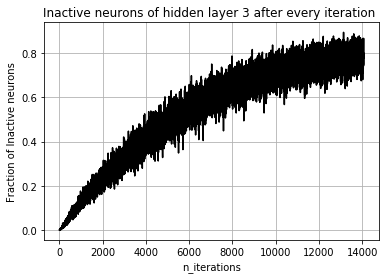

In [475]:
n_iterations = [i for i in range(len(inactive_3))]
#plt.plot(n_iterations,np.array(inactive_tot)/3,'b')
#plt.plot(n_iterations,inactive_1,'r')
#plt.plot(n_iterations,inactive_2,'g')
plt.plot(n_iterations,inactive_3,'k')
plt.grid()
plt.xlabel('n_iterations')
plt.ylabel('Fraction of Inactive neurons')
plt.title('Inactive neurons of hidden layer 3 after every iteration ')
plt.show()

# Add Gaussian Noise in forward pass

In [18]:
def add_gaussian_noise_fwd_pass(X,parameters,activation):
    
    A = {}
    Z = {}
    for i in range(1,len(parameters)//2+1):
        if (i == 1):
            Z['Z'+str(i)] = np.matmul(parameters['W'+str(i)],X) + parameters['b'+str(i)] 
            A['A'+str(i)] = activation_function(activation[i-1],Z['Z'+str(i)]) + np.random.normal(0,0.1, Z['Z'+str(i)].shape)
        else:
            Z['Z'+str(i)] = np.matmul(parameters['W'+str(i)],A['A'+str(i-1)]) + parameters['b'+str(i)]
            A['A'+str(i)] = activation_function(activation[i-1],Z['Z'+str(i)]) + np.random.normal(0,0.1, Z['Z'+str(i)].shape)
   
    return A,Z
    
    

In [19]:
def train_model_fwd_noise(train_X,test_X, test_Y,train_Y, activation ,batch_size, epochs,lr):
    data = np.concatenate((train_X.T,train_Y.T),axis = 1)
    np.random.shuffle(data)
    X_train = data[:,:784]
    Y_train = data[:,784:]
    cost_train = []
    cost_test = []
    parameters = initialize_parameters([784,500,250,100,10])
    activation_rev = activation[::-1]
    x = 1
    for i in range(epochs):
        train_cost = 0
        test_cost = 0
        print('Epoch '+str(i)+' [' ,end='')
        for j in range(0, X_train.shape[0], batch_size):
                print('=',end ='')
                X_train_mini = X_train[j:j + batch_size,:]
                Y_train_mini = Y_train[j:j + batch_size,:]
                A,Z= add_gaussian_noise_fwd_pass(X_train_mini.T, parameters, activation)
                
                
                dW,db = backward_propagation(parameters,A,Z,X_train_mini.T,Y_train_mini.T,activation_rev)

                parameters = update_parameters(dW,db,lr,parameters)
                if (x%200==0):
                    A1,_= forward_propagation(train_X, parameters, activation)
                    train_pred = A1['A'+str(len(A1))]
                    A2,_= forward_propagation(test_X, parameters, activation)
                    test_pred = A2['A'+str(len(A2))]


                    train_cost = round(compute_cost(train_pred,train_Y),4)
                    test_cost = round(compute_cost(test_pred,test_Y),4)
                    cost_train.append(train_cost)
                    cost_test.append(test_cost)

                x = x+1
        print('training loss = ',train_cost,' test loss =',test_cost)
             
    return cost_train,cost_test,parameters

In [20]:
cost_train,cost_test,parameters = train_model_fwd_noise(train_X,test_X,test_Y,train_Y,['tanh','tanh','tanh','softmax'],batch_size = 64,epochs = 15,lr = 0.2)

Epoch 0 [==========================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================training loss =  0.1661  test loss = 0.1698
Epoch 1 [

In [21]:
cfm = metrics(train_X,test_X ,parameters,['tanh','tanh','tanh','softmax'],train_labels,test_labels)

Training Accuracy =  0.9841666666666666
Test Accuracy =  0.971
precision =  0.9710309307386935 and recall =  0.971 and f1_score = 0.9709643495591951


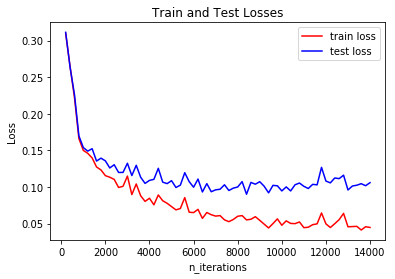

In [22]:
epoch = [200*i for i in range(1,71)]
plt.plot(epoch,cost_train,'-r')
plt.plot(epoch,cost_test,'-b', label= 'test loss')
plt.title('Train and Test Losses')
plt.xlabel('n_iterations')
plt.ylabel('Loss')
plt.gca().legend(('train loss','test loss'))#,'test loss'))
plt.savefig('relu_0.02traintest_loss.png')
plt.show()


# Add gaussian noise in backward pass

In [20]:
def add_gaussian_noise_bwd_pass(parameters,A,Z,X,Y,activation):
    for i in range(1,len(A)+1):
        A['A'+str(i)] = np.random.normal(0,0.05,Z['Z'+str(i)].shape)
    A['A0'] = X
    del_L = A['A' + str(len(Z))] - Y
    delta = [del_L]
    dW = {}
    db = {}
    L = len(Z)
    m = X.shape[1]
    for i in range(1,L+1):
        dW['dW'+str(L-i+1)] = (1/m)*np.matmul(delta[-1],np.transpose(A['A'+str(L-i)]))
        db['db'+str(L-i+1)] = (1/m)*np.sum(delta[-1],axis = 1,keepdims = True)
        if (i == L):
            delta.append(np.matmul(np.transpose(parameters['W'+str(L-i+1)]),delta[-1]))
        else:
            delta.append(np.matmul(np.transpose(parameters['W'+str(L-i+1)]),delta[-1])*(activation_derivatives(activation[i],Z['Z'+str(L-i)])))

        
   
            
    return dW,db   
    
    

In [21]:
def train_model_bwd_noise(train_X,test_X, test_Y,train_Y, activation ,batch_size, epochs,lr):
    data = np.concatenate((train_X.T,train_Y.T),axis = 1)
    np.random.shuffle(data)
    X_train = data[:,:784]
    Y_train = data[:,784:]
    cost_train = []
    cost_test = []
    parameters = initialize_parameters([784,500,250,100,10])
    activation_rev = activation[::-1]
    x = 1
    for i in range(epochs):
        train_cost = 0
        test_cost = 0
        print('Epoch '+str(i)+' [' ,end='')
        for j in range(0, X_train.shape[0], batch_size):
                print('=',end ='')
                X_train_mini = X_train[j:j + batch_size,:]
                Y_train_mini = Y_train[j:j + batch_size,:]
                A,Z= forward_propagation(X_train_mini.T, parameters, activation)
                
                
                dW,db = add_gaussian_noise_bwd_pass(parameters,A,Z,X_train_mini.T,Y_train_mini.T,activation_rev)

                parameters = update_parameters(dW,db,lr,parameters)
                if (x%200==0):
                    A1,_= forward_propagation(train_X, parameters, activation)
                    train_pred = A1['A'+str(len(A1))]
                    A2,_= forward_propagation(test_X, parameters, activation)
                    test_pred = A2['A'+str(len(A2))]


                    train_cost = round(compute_cost(train_pred,train_Y),4)
                    test_cost = round(compute_cost(test_pred,test_Y),4)
                    cost_train.append(train_cost)
                    cost_test.append(test_cost)

                x = x+1
        print('training loss = ',train_cost,' test loss =',test_cost)
             
    return cost_train,cost_test,parameters

In [26]:
cost_train,cost_test,parameters = train_model_bwd_noise(train_X,test_X,test_Y,train_Y,['tanh','tanh','tanh','softmax'],batch_size = 64,epochs = 15,lr = 0.02)

NameError: name 'train_model_bwd_noise' is not defined

In [32]:
cfm = metrics(train_X,test_X ,parameters,['tanh','tanh','tanh','softmax'],train_labels,test_labels)

Training Accuracy =  0.8282
Test Accuracy =  0.8366
precision =  0.8659912975861789 and recall =  0.8366 and f1_score = 0.831150319507926


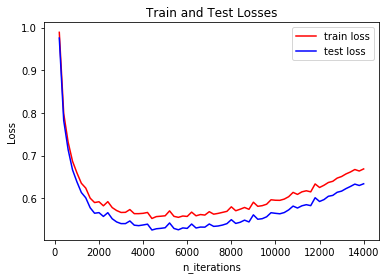

In [33]:
epoch = [200*i for i in range(1,71)]
plt.plot(epoch,cost_train,'-r')
plt.plot(epoch,cost_test,'-b', label= 'test loss')
plt.title('Train and Test Losses')
plt.xlabel('n_iterations')
plt.ylabel('Loss')
plt.gca().legend(('train loss','test loss'))#,'test loss'))
plt.savefig('relu_0.02traintest_loss.png')
plt.show()


# Data augmentation by adding noise

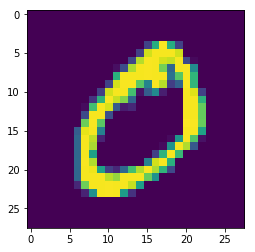

In [48]:
plt.imshow(train_images[1]+np.random.normal(0,0,(28,28)))

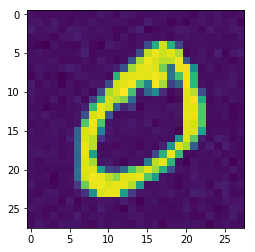

In [54]:
plt.imshow(train_images[1]+np.random.normal(0,4,(28,28)))

In [55]:
train_images_with_noise= []
for i in range(train_images.shape[0]):
    train_images_with_noise.append(train_images[i]+np.random.normal(0,4,(28,28)))

In [74]:
train_images_with_noise = np.array(train_images_with_noise)
train_images_augmented = np.concatenate((train_images,train_images_with_noise),axis = 0)
train_X_aug = np.transpose(train_images_augmented.reshape([120000,784]))                  
train_X_aug = train_X_aug/255.
train_Y_aug = np.concatenate((train_Y.T,train_Y.T))
train_Y_aug = train_Y_aug.T


In [77]:
cost_train,cost_test,parameters = train_model(train_X_aug,test_X,test_Y,train_Y_aug,['relu','relu','relu','softmax'],batch_size = 64,epochs = 15,lr = 0.2)

Epoch 0 [===============================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

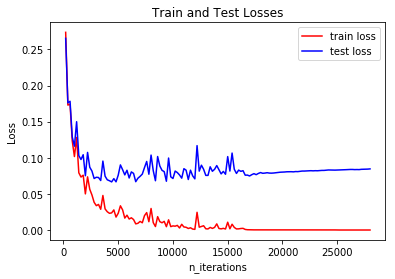

In [79]:
epoch = [200*i for i in range(1,141)]
plt.plot(epoch,cost_train,'-r')
plt.plot(epoch,cost_test,'-b', label= 'test loss')
plt.title('Train and Test Losses')
plt.xlabel('n_iterations')
plt.ylabel('Loss')
plt.gca().legend(('train loss','test loss'))#,'test loss'))
plt.savefig('relu_0.02traintest_loss.png')
plt.show()


In [81]:
cfm = metrics(train_X,test_X ,parameters,['relu','relu','relu','softmax'],train_labels,test_labels)
cfm

Training Accuracy =  1.0
Test Accuracy =  0.9853
precision =  0.9853207401693115 and recall =  0.9853 and f1_score = 0.985301729467663


Predicted    0     1     2     3    4    5    6     7    8     9  __all__
Actual                                                                   
0          973     0     1     0    0    0    3     1    1     1      980
1            0  1127     1     1    0    0    2     1    3     0     1135
2            3     0  1016     3    3    0    0     3    4     0     1032
3            0     0     1   997    0    2    0     2    3     5     1010
4            1     0     2     1  964    0    4     2    0     8      982
5            3     0     0     6    2  872    3     1    2     3      892
6            2     2     0     1    6    3  944     0    0     0      958
7            0     3     6     1    0    0    0  1008    4     6     1028
8            0     0     2     3    1    1    1     2  960     4      974
9            3     2     0     1    6    3    0     1    1   992     1009
__all__    985  1134  1029  1014  982  881  957  1021  978  1019    10000

# L-2 Regularization 

In [21]:
def cost_with_reg(A_L,parameters,aplha,Y):
    
    m =Y.shape[1]
    cost_reg_term = 0
    for i in range(1,(len(parameters)//2)+1):
        cost_reg_term = cost_reg_term + (alpha/(2*m))*sum(sum(parameters['W'+str(i)]*parameters['W'+str(i)]))
    cost = -(1/m)*sum(sum(Y*np.log(A_L))) 
    return cost

In [22]:
def backward_propagation_with_reg(parameters,A,Z,X,Y,activation,alpha):
    
    A['A0'] = X
    del_L = A['A' + str(len(Z))] - Y
    delta = [del_L]
    dW = {}
    db = {}
    L = len(Z)
    m = X.shape[1]
    for i in range(1,L+1):
        dW['dW'+str(L-i+1)] = (1/m)*np.matmul(delta[-1],np.transpose(A['A'+str(L-i)])) + (1/m)*alpha*parameters['W'+str(L-i+1)]
        db['db'+str(L-i+1)] = (1/m)*np.sum(delta[-1],axis = 1,keepdims = True)
        if (i == L):
            delta.append(np.matmul(np.transpose(parameters['W'+str(L-i+1)]),delta[-1]))
        else:
            delta.append(np.matmul(np.transpose(parameters['W'+str(L-i+1)]),delta[-1])*(activation_derivatives(activation[i],Z['Z'+str(L-i)])))

        
   
            
    return dW,db   
    
    

In [23]:
def train_model_with_reg(train_X,test_X, test_Y,train_Y, activation ,batch_size, epochs,lr,alpha):
    data = np.concatenate((train_X.T,train_Y.T),axis = 1)
    np.random.shuffle(data)
    X_train = data[:,:784]
    Y_train = data[:,784:]
    cost_train = []
    cost_test = []
    parameters = initialize_parameters([784,500,250,100,10])
    activation_rev = activation[::-1]
    x = 1
    for i in range(epochs):
        train_cost = 0
        test_cost = 0
        print('Epoch '+str(i)+' [' ,end='')
        for j in range(0, X_train.shape[0], batch_size):
                print('=',end ='')
                X_train_mini = X_train[j:j + batch_size,:]
                Y_train_mini = Y_train[j:j + batch_size,:]
                A,Z= add_gaussian_noise_fwd_pass(X_train_mini.T, parameters, activation)
                
                
                dW,db = backward_propagation(parameters,A,Z,X_train_mini.T,Y_train_mini.T,activation_rev)

                parameters = update_parameters(dW,db,lr,parameters)
                if (x%200==0):
                    A1,_= forward_propagation(train_X, parameters, activation)
                    train_pred = A1['A'+str(len(A1))]
                    A2,_= forward_propagation(test_X, parameters, activation)
                    test_pred = A2['A'+str(len(A2))]


                    train_cost = round(compute_cost(train_pred,train_Y),4)
                    test_cost = round(compute_cost(test_pred,test_Y),4)
                    cost_train.append(train_cost)
                    cost_test.append(test_cost)

                x = x+1
        print('training loss = ',train_cost,' test loss =',test_cost)
             
    return cost_train,cost_test,parameters

In [87]:
cost_train,cost_test,parameters = train_model_with_reg(train_X,test_X, test_Y,train_Y, activation = ['relu','relu','relu','softmax'] ,batch_size = 64, epochs = 15,lr = 0.02,alpha = 0.01)

Epoch 0 [==========================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================training loss =  0.3158  test loss = 0.2992
Epoch 1 [

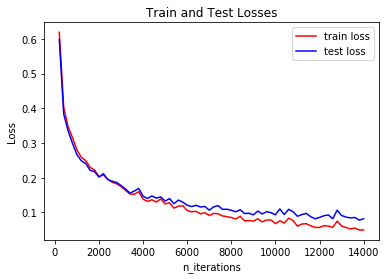

In [91]:
epoch = [200*i for i in range(1,71)]
plt.plot(epoch,cost_train,'-r')
plt.plot(epoch,cost_test,'-b', label= 'test loss')
plt.title('Train and Test Losses')
plt.xlabel('n_iterations')
plt.ylabel('Loss')
plt.gca().legend(('train loss','test loss'))#,'test loss'))
plt.savefig('relu_0.02traintest_loss.png')
plt.show()


In [93]:
cfm = metrics(train_X,test_X ,parameters,['relu','relu','relu','softmax'],train_labels,test_labels)
cfm

Training Accuracy =  0.9798333333333333
Test Accuracy =  0.9689
precision =  0.9695577881143745 and recall =  0.9689 and f1_score = 0.9688546677673657


Predicted    0     1     2     3    4    5    6     7     8    9  __all__
Actual                                                                   
0          954     0     9     2    2    0    4     2     3    4      980
1            0  1119     5     2    0    0    3     1     5    0     1135
2            1     1  1021     1    1    0    0     5     2    0     1032
3            0     0     4   995    0    0    0     5     5    1     1010
4            0     0     6     0  961    0    3     1     2    9      982
5            4     1     1    45    2  807    8     1    21    2      892
6            3     2     3     1    7    2  934     1     5    0      958
7            0     5     8     2    3    0    1   999     3    7     1028
8            3     0     7     9    2    0    2     2   949    0      974
9            1     5     1    11   14    0    2     9    16  950     1009
__all__    966  1133  1065  1068  992  809  957  1026  1011  973    10000

# Hand Crafted Features

In [9]:
import cv2

In [10]:
winSize = (28,28)
blockSize =(14,14)
blockStride = (7,7)
cellSize = (7,7)
nbins = 10
derivAperture = 1
winSigma = -1
histogramNormType = 0
L2HysThreshold  = 0.2
gammaCorrection =1
nlevels = 64
signedGradients = True
hog = cv2.HOGDescriptor(winSize,blockSize,blockStride,cellSize,nbins,derivAperture,winSigma,histogramNormType,L2HysThreshold,gammaCorrection,nlevels,signedGradients)

In [11]:
train_X_hog = []
for i in range(train_images.shape[0]):
    train_X_hog.append(np.squeeze(hog.compute(train_images[i])))

In [12]:
test_X_hog = []
for i in range(test_images.shape[0]):
    test_X_hog.append(np.squeeze(hog.compute(test_images[i])))

In [13]:
train_X_hog = np.array(train_X_hog)
test_X_hog = np.array(test_X_hog)

In [14]:
scaler = StandardScaler()
scaler.fit(train_X_hog)
train_X_hog1 = scaler.transform(train_X_hog)
test_X_hog1 = scaler.transform(test_X_hog)

In [15]:
train_X_hog = train_X_hog1.T
test_X_hog = test_X_hog1.T

In [43]:
def train_model_hog(train_X,test_X, test_Y,train_Y, activation ,batch_size, epochs,lr,layers):
    data = np.concatenate((train_X.T,train_Y.T),axis = 1)
    np.random.shuffle(data)
    X_train = data[:,:train_X.shape[0]]
    Y_train = data[:,train_X.shape[0]:]
    cost_train = []
    cost_test = []
    parameters = initialize_parameters(layers)
    activation_rev = activation[::-1]
    x = 1
    for i in range(epochs):
        train_cost = 0
        test_cost = 0
        print('Epoch '+str(i)+' [' ,end='')
        for j in range(0, X_train.shape[0], batch_size):
                print('=',end ='')
                X_train_mini = X_train[j:j + batch_size,:]
                Y_train_mini = Y_train[j:j + batch_size,:]
                A,Z= forward_propagation(X_train_mini.T, parameters, activation)
                
                
                dW,db = backward_propagation(parameters,A,Z,X_train_mini.T,Y_train_mini.T,activation_rev)

                parameters = update_parameters(dW,db,lr,parameters)
                if (x%200==0):
                    A1,_= forward_propagation(train_X, parameters, activation)
                    train_pred = A1['A'+str(len(A1))]
                    A2,_= forward_propagation(test_X, parameters, activation)
                    test_pred = A2['A'+str(len(A2))]


                    train_cost = round(compute_cost(train_pred,train_Y),4)
                    test_cost = round(compute_cost(test_pred,test_Y),4)
                    cost_train.append(train_cost)
                    cost_test.append(test_cost)

                x = x+1
        print(train_cost,test_cost)
             
    return cost_train,cost_test,parameters

In [46]:
cost_train,cost_test,parameters = train_model_hog(train_X_hog,test_X_hog,test_Y,train_Y,['sigmoid','sigmoid','sigmoid','softmax'],batch_size = 64,epochs = 40,lr = 0.001,layers = [360,150,75,10])

Epoch 0 [==========================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================2.0746 2.0731
Epoch 1 [==============================

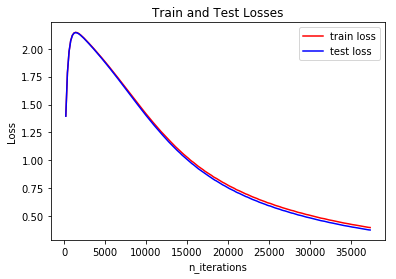

In [49]:
epoch = [200*i for i in range(1,188)]
plt.plot(epoch,cost_train,'-r')
plt.plot(epoch,cost_test,'-b', label= 'test loss')
plt.title('Train and Test Losses')
plt.xlabel('n_iterations')
plt.ylabel('Loss')
plt.gca().legend(('train loss','test loss'))#,'test loss'))
plt.savefig('relu_0.02traintest_loss.png')
plt.show()


In [47]:
cfm = metrics(train_X_hog,test_X_hog,parameters,['sigmoid','sigmoid','sigmoid','softmax'],train_labels,test_labels)
cfm

Training Accuracy =  0.9569666666666666
Test Accuracy =  0.9584
precision =  0.9583890116130901 and recall =  0.9584 and f1_score = 0.9581916242570071


Predicted     0     1     2     3    4    5    6     7    8    9  __all__
Actual                                                                   
0           971     1     0     0    0    0    7     1    0    0      980
1             0  1123     7     0    0    0    5     0    0    0     1135
2            10     2   998     4    0    0    1    12    4    1     1032
3             3     0     5   985    0    4    0     7    2    4     1010
4             1    10     2     0  949    0    7     1    1   11      982
5             4     0     0    15    0  854    8     1   10    0      892
6             4     3     0     0    3    6  940     0    2    0      958
7             2     5    31     1    6    0    0   956    2   25     1028
8            18     5     3    16    9   13   12     8  874   16      974
9             9     8     0     5   15    5    0    18   15  934     1009
__all__    1022  1157  1046  1026  982  882  980  1004  910  991    10000

# SVM

In [51]:

from sklearn import svm
clf = svm.SVC(C=10, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=True)
clf.fit(train_X_hog.T, train_labels)  


[LibSVM]

SVC(C=10, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=True)

In [52]:
y_train_pred = clf.predict(train_X_hog.T)
y_test_pred = clf.predict(test_X_hog.T)
print('training accuracy= ',accuracy_score(train_labels,y_train_pred))
print('test accuracy= ',accuracy_score(test_labels,y_test_pred))

training accuracy=  0.9998833333333333
test accuracy=  0.9939


# KNN

In [18]:
from sklearn.neighbors import KNeighborsClassifier
neigh = KNeighborsClassifier(n_neighbors=3,n_jobs  = -1)
neigh.fit(train_X_hog.T, train_labels) 

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=-1, n_neighbors=3, p=2,
           weights='uniform')

In [19]:
y_train_pred = neigh.predict(train_X_hog.T)
y_test_pred = neigh.predict(test_X_hog.T)
print('training accuracy= ',accuracy_score(train_labels,y_train_pred))
print('test accuracy= ',accuracy_score(test_labels,y_test_pred))

training accuracy=  0.999843333333
test accuracy=  0.9924
